<div style="background-color: darkred; padding: 10px; color: white;">

# Demo: Supervoxel-Based Loss

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Detect Critical Supervoxels
    
</div>

### Imports

In [1]:
from PIL import Image
from scipy.ndimage import label

import matplotlib.pyplot as plt
import numpy as np

from supervoxel_loss.critical_detection_2d import (
    detect_critical_2d, get_false_negative_mask
)

### Load Image Data

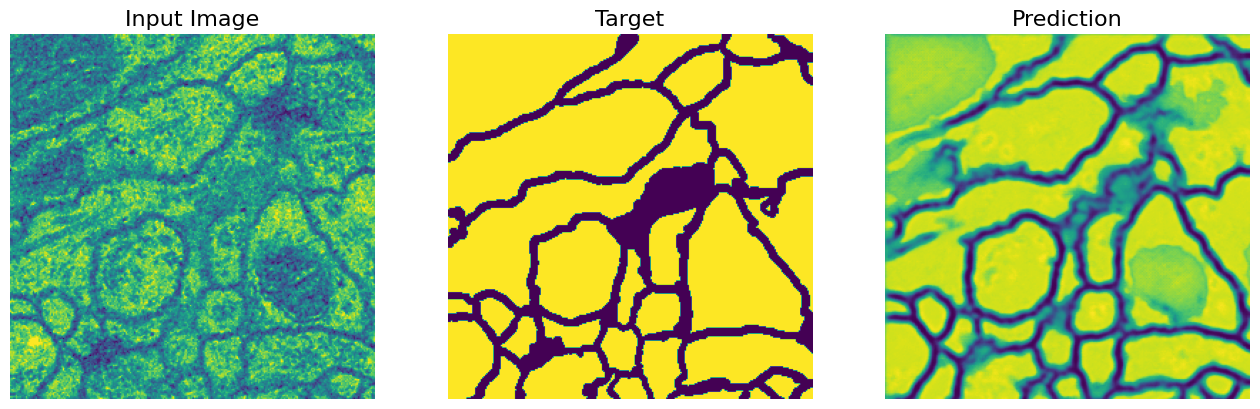

In [2]:
# Read images
input_img = np.array(Image.open('input.png'))
target = np.array(Image.open('target.png')) // 255
pred = np.array(Image.open('pred.png')) / 255

# Visualize images
fig, axes = plt.subplots(1, 3, figsize=(16, 14))

axes[0].imshow(input_img)
axes[0].set_title('Input Image', fontsize=16)

axes[1].imshow(target)
axes[1].set_title('Target', fontsize=16)

axes[2].imshow(pred)
axes[2].set_title('Prediction', fontsize=16)

# Hide axes
for ax in axes:
    ax.axis('off')

### Compute Critical Supervoxels

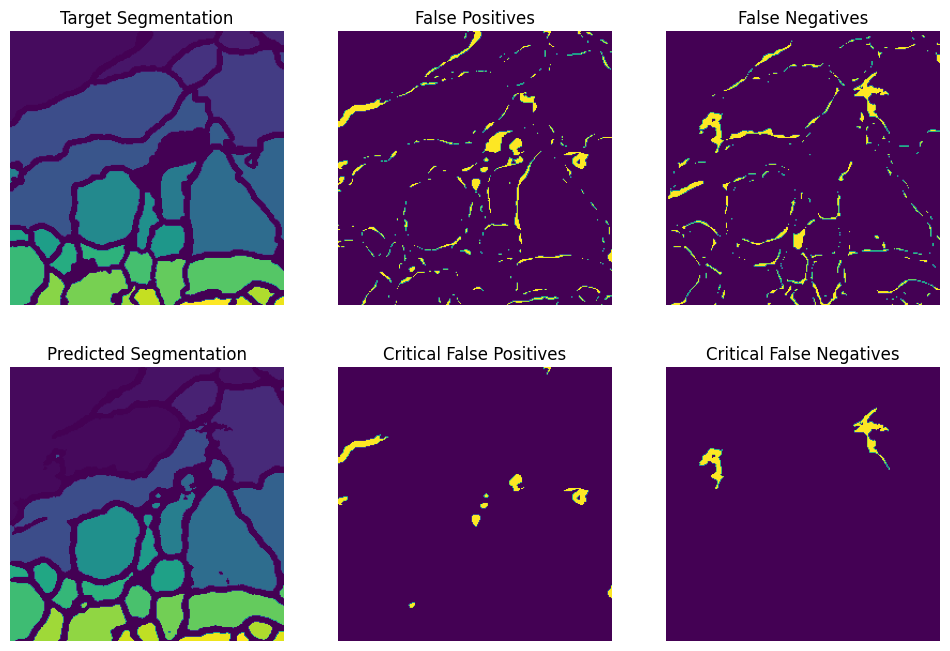

In [3]:
# Get segmentation masks
target_segmentation, _ = label(target)
pred_segmentation, _ = label(pred > 0.5)

# Compute false positives and false negatives -- for visualization purposes
false_negatives = get_false_negative_mask(target_segmentation, pred_segmentation)
false_positives = get_false_negative_mask(pred_segmentation, target_segmentation)

# Compute critical supervoxels
pos_critical_mask = detect_critical_2d(pred_segmentation, target_segmentation)
neg_critical_mask = detect_critical_2d(target_segmentation, pred_segmentation)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes_row_1 = axes[0]
axes_row_2 = axes[1]

# Row 1
axes_row_1[0].imshow(target_segmentation)
axes_row_1[0].set_title('Target Segmentation')
axes_row_1[0].axis('off')

axes_row_1[1].imshow(false_positives)
axes_row_1[1].set_title('False Positives')
axes_row_1[1].axis('off')

axes_row_1[2].imshow(false_negatives)
axes_row_1[2].set_title('False Negatives')
axes_row_1[2].axis('off')

# Row 2
axes_row_2[0].imshow(pred_segmentation)
axes_row_2[0].set_title('Predicted Segmentation')
axes_row_2[0].axis('off')

axes_row_2[1].imshow(pos_critical_mask)
axes_row_2[1].set_title('Critical False Positives')
axes_row_2[1].axis('off')

axes_row_2[2].imshow(neg_critical_mask)
axes_row_2[2].set_title('Critical False Negatives')
axes_row_2[2].axis('off')

plt.show()

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Supervoxel-Based Loss Function
    
</div>

### Imports

In [4]:
import torch
import torch.nn as nn

from supervoxel_loss.loss import SuperVoxelLoss2D

### Subroutines

In [5]:
def get_loss_mask(pred, target, alpha, beta):
    # Initialize loss
    loss_function = SuperVoxelLoss2D(
        alpha=alpha,
        beta=beta,
        criterion=nn.BCELoss(reduction="none"),
        return_mask=True,
        threshold=0.5
    )

    # Compute loss
    target_tensor = to_tensor(target)
    pred_tensor = to_tensor(pred)
    loss_mask = loss_function(pred_tensor, target_tensor)
    return np.array(loss_mask[0, 0, ...].detach().cpu())

def to_tensor(arr):
    tensor = torch.from_numpy(arr).to("cuda:0", dtype=torch.float32)
    return tensor.unsqueeze(0).unsqueeze(0)

### Visualize Loss

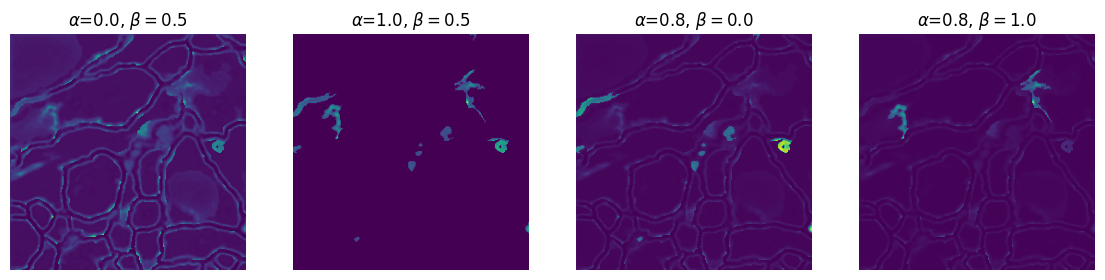

In [6]:
# Parameters
alphas = [0.0, 1.0, 0.8, 0.8] # large alpha means more weight on critical supervoxels
betas = [0.5, 0.5, 0.0, 1.0]  # large beta means more weigh on critical false negatives

# Visualize results
fig, axes = plt.subplots(1, len(alphas), figsize=(14, 14))
for i, (alpha, beta) in enumerate(zip(alphas, betas)):
    loss_mask = get_loss_mask(pred, target, alpha, beta)
    axes[i].imshow(255 * loss_mask)
    axes[i].set_title(f"$\\alpha$={alpha}, $\\beta={beta}$")
    axes[i].axis("off")
plt.show()